In [1]:
import cv2 as cv
import subprocess
import re
from pyproj import Transformer
from shapely import geometry, affinity
import rasterio
import rasterio.transform
import numpy as np
from PIL import Image
from osgeo import gdal; gdal.UseExceptions()
import os
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import affine
import torch
import networkx
#import pandas as pd
import geopandas as gpd
from datetime import datetime
import geopandas as gpd
from util import recreate_dir, load_config
from p_tqdm import p_map
import pickle
import pandas as pd
import shutil

In [2]:
DATA_DIR = "data/20220324_kocinka_rybna"
CFG = load_config(f"{DATA_DIR}/config.py").GEOREFERENCING

In [3]:
# #configure logging to file
# import logging
# log_path = f"{DATA_DIR}/logs/georeferencing_{datetime.now().strftime('%d%m%Y%H%M%S')}.log"
# os.makedirs(os.path.dirname(log_path), exist_ok=True)
# logging.basicConfig(filename=log_path,level=logging.INFO, format='%(asctime)s %(levelname)-8s %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
# logger = logging.getLogger(__name__)
# logger.handlers.clear()
# #logger.addHandler(logging.StreamHandler())
# logger.info("Starting procedure")

In [4]:
TMP_DIR = f"{DATA_DIR}/tmp"
os.makedirs(TMP_DIR, exist_ok=True)

TIF_RAW_DIR = f"{DATA_DIR}/tif_raw"
assert os.path.isdir(TIF_RAW_DIR), f"{TIF_RAW_DIR} does not exist. Run 1_conversion.ipynb"
TIF_DEVIGNETTE_DIR = f"{DATA_DIR}/tif_devignette"
assert os.path.isdir(TIF_DEVIGNETTE_DIR), f"{TIF_DEVIGNETTE_DIR} does not exist. Run 2_devignetting.ipynb"

GEOTIF_RAW_DIR = f"{DATA_DIR}/geotif_raw"
GEOTIF_DEVIGNETTE_DIR = f"{DATA_DIR}/geotif_devignette"
GEOTIF_INIT_DIR = f"{DATA_DIR}/geotif_init"

OVERLAYS_DIR = f"{DATA_DIR}/overlays"
CACHE_DIR = f"{DATA_DIR}/cache"
os.makedirs(CACHE_DIR, exist_ok=True)

In [5]:
# seeding
cv.setRNGSeed(0)

class Stitcher(object):
    """Stitches images together. Params default to standard ones.

    Args:

        lowe_ratio (float): Lowe's ratio for discarding false matches
            the lower, the more false matches are discarded, defaults to 0.7
        min_inliers (int): minimum number of matches to attempt
            estimation of affine transform, the higher, the more high-quality
            the match, defaults to 200, this is also used for checking whether
            a higher resolution image should be used, higher res matching
            is attempted when no. of inliers from RANSAC < min_inliers
        ransac_reproj_threshold (float): max reprojection error in RANSAC
            to consider a point as an inlier, the higher, the more tolerant
            RANSAC is, defaults to 3.0
    """

    def __init__(self,
                 lowe_ratio=0.7,
                 min_inliers=10):
        # create feature detector
        self.fd = cv.SIFT_create()
        # feature matcher
        FLANN_INDEX_KDTREE = 1
        self.mt = cv.FlannBasedMatcher({'algorithm': FLANN_INDEX_KDTREE})
        # Lowe's ratio for discarding false matches
        self.lowe_ratio = lowe_ratio
        # minimum feature matches to attempt transform estimation
        # if RANSAC inliers < min_inliers, higher resolution images are used
        self.min_inliers = min_inliers

    def relative_affine(self, img0, img1):
        """Estimates the relative affine transformation.

        Args:
            img0, img1 (numpy.Array)

        Returns:
            affine.Affine or NoneType: affine transform to fit
                img1 onto img0, None if no match is found
        """
       
        
        
        # detect features, compute descriptors
        kp0, des0 = self.fd.detectAndCompute(img0, mask=None)
        # logger.info(f"len(kp0) = {len(kp0)}")
        kp1, des1 = self.fd.detectAndCompute(img1, mask=None)
        # logger.info(f"len(kp1) = {len(kp1)}")
        # match descriptors
        matches = self.mt.knnMatch(des0, des1, k=2)  # query, train
        # logger.info(f"number of matches {len(matches)}")
        # store all the good matches as per Lowe's ratio test
        good = []
        for m0, m1 in matches:
            if m0.distance < self.lowe_ratio * m1.distance:
                good.append(m0)
        # logger.info(f"number of good matches {len(good)} / {self.min_inliers}")
        # with all good matches, estimate affine transform w/ RANSAC
        if len(good) < self.min_inliers:
            return None
        pts0 = np.array([kp0[m.queryIdx].pt for m in good])
        pts1 = np.array([kp1[m.trainIdx].pt for m in good])

        #use cv.estimateAffine2D instead
        transform, inliers = cv.estimateAffine2D(
            pts1, pts0,
            method=cv.RANSAC)
        # logger.info(f"number of inliers {inliers.sum()}")
        if transform is None:
            return None
        transform = rasterio.transform.Affine(*transform.flatten())
        return transform

    def absolute_affine(self, src_img, dst_img, dst_trans):
        """Stitch source image to destination image.

        Args:
            src_img, dst_img (str): file path
            dst_trans (affine.Affine): dst_img image transform

        Returns:
            affine.Affine or NoneType: affine transform to fit
                src_img onto dst_img, None if no match is found
                the relative transform is in terms of the original images
        """
        relative_trans = self.relative_affine(dst_img, src_img)
        # return if transform is found
        if relative_trans is None:
            # logger.info("Relative transform is NONE.")
            return None
        
        # return the absolute transform
        trans = dst_trans * relative_trans
        return trans
    
def img2geotif(in_path, out_path, transform, crs):
    """Convert image to geotiff.
    Args:
        img_path (str): image file path
        transform (affine.Affine or numpy.array): affine transform 3x3 matrix
        out_path (str): output geotiff file path
    """
    #get file name from out_path
    file_name = out_path.split('/')[-1]
    if not isinstance(transform, affine.Affine):
        transform = affine.Affine(*transform.flatten()[:6])
    arr = np.array(Image.open(in_path)).squeeze()
    with rasterio.open(f"{TMP_DIR}/{file_name}", 'w', driver='GTiff', height=arr.shape[0], width=arr.shape[1], count=1, dtype=arr.dtype, crs=crs, transform=transform) as dst:
        dst.write(arr, 1)
    gdal.Warp(out_path, f"{TMP_DIR}/{file_name}", format='GTiff', dstSRS=crs, dstNodata=-9999)

def estimate_affine_from_params(translation_x, translation_y, scale, rotation):
    """Estimates affine transform from parameters.
    Args:
        translation_x (float): translation in x direction
        translation_y (float): translation in y direction
        scale (float): scale
        rotation (float): rotation in radians
    Returns:
        affine (numpy.array): affine transform 2x3 matrix
    """
    #Non-standard orientation of the coordinate system (cos, sin, x, sin, -cos, y)
    transform = np.array([[scale*np.cos(rotation), scale*np.sin(rotation), translation_x], [scale*np.sin(rotation), -scale*np.cos(rotation), translation_y]])
    return transform

def dms2dec(dms):
    """Converts DMS (degrees, minutes, seconds) to decimal degrees.
    Args:
        dms (list): DMS coordinates
    Returns:
        float: decimal degrees
    """
    d = float(dms[0])
    m = float(dms[1])
    s = float(dms[2])
    return (d+m/60+s/3600)*(-1 if dms[3] in ['W', 'S'] else 1)

def fetch_H20t_exif(img_path):
    """Camera dependent EXIF data fetcher.
    Args:
        img_path (str): image file path
    Returns:
        exif (dict): EXIF data with fields: lat, lon, alt, yaw, dfov_deg, width, height
    """
    lat, lon, yaw, alt = subprocess.run(['exiftool', '-GPSLatitude', '-GPSLongitude', '-GimbalYawDegree', '-RelativeAltitude', img_path], stdout=subprocess.PIPE).stdout.decode("utf-8").splitlines()
    lat = lat.split(":",1)[1].strip()
    lat = [x.strip() for x in re.split('[deg\'"]', lat) if x]
    lat = dms2dec(lat)
    lon = lon.split(":",1)[1].strip()
    lon = [x.strip() for x in re.split('[deg\'"]', lon) if x]
    lon = dms2dec(lon)
    yaw = float(yaw.split(":",1)[1].strip())
    alt = float(alt.split(":",1)[1].strip())
    return {'lat': lat, 'lon': lon, 'alt': alt, 'yaw': yaw}

class ExifGeoreferencer:
    """Georeference images by EXIF data."""
    def __init__(self, width=640, height=512, dfov_d=40., utm_zone="EPSG:32634", exif_fetcher=fetch_H20t_exif):
        """Initialize georeferencer.
        Args:
            width, height (int): image size in pixels
            dfov_d (float): diagonal field of view in degrees
            utm_zone (str): UTM zone
            exif_fetcher (function): function to fetch EXIF data
        """
        self.dfov_d = dfov_d
        self.width = width
        self.height = height
        self.diag_pix = np.sqrt(width**2 + height**2)
        self.hcoef = width/self.diag_pix
        self.vcoef = height/self.diag_pix
        self.utm_zone = utm_zone
        self.exif_fetcher = exif_fetcher

    def estimate_transforms(self, img_path):
        """Get transform parameters from EXIF data.
        Args:
            img_path (str): image file path
        Returns:
            translation_x, translation_y, rotation, scale (float): transform parameters
            footprint (geometry.Polygon): image footprint in UTM coordinates
        """
        exif = self.exif_fetcher(img_path)
        dfov_m = 2*exif["alt"]*np.tan(self.dfov_d/2*np.pi/180)
        vfov_m = self.vcoef*dfov_m
        hfov_m = self.hcoef*dfov_m
        pixel_size = dfov_m/819.5999023914046
        transformer = Transformer.from_crs("epsg:4326", self.utm_zone, always_xy=True)
        x, y = transformer.transform(exif["lon"], exif["lat"])
        #convert degres to radians
        rotation = -exif["yaw"]
        scale = pixel_size
        footprint = geometry.Polygon([(x-hfov_m/2, y-vfov_m/2), (x+hfov_m/2, y-vfov_m/2), (x+hfov_m/2, y+vfov_m/2), (x-hfov_m/2, y+vfov_m/2)])
        footprint = affinity.rotate(footprint,rotation, origin="centroid")
        # print(translation_x, translation_y)
        #print(footprint.exterior.coords[3][0], footprint.exterior.coords[3][1])
        translation_x = footprint.exterior.coords[3][0]
        translation_y = footprint.exterior.coords[3][1]
        #rotation to radians
        rotation = (rotation)*np.pi/180
        return translation_x, translation_y, scale, rotation, footprint

    def estimate_affine_from_img(self, img_path):
        translation_x, translation_y, scale, rotation = self.estimate_transforms(img_path)
        return estimate_affine_from_params(translation_x, translation_y, scale, rotation)

Get initial georeferences for all images basing on EXIF data

In [6]:
# if CFG.CACHE and os.path.exists(f"{CACHE_DIR}/all_images.pkl"):
#     with open(f"{CACHE_DIR}/all_images.pkl", 'rb') as f:
#         all_images = pickle.load(f)
#     #all_images = gpd.read_pickle(f"{CACHE_DIR}/all_images.pkl")
# else:
exifGeoreferencer = ExifGeoreferencer(width=CFG.WIDTH, height=CFG.HEIGHT, dfov_d=CFG.DFOV, utm_zone="EPSG:32634", exif_fetcher=fetch_H20t_exif)
def init_georeference(file_path):
    file_name = os.path.basename(file_path)
    x, y, scale, rotation, footprint = exifGeoreferencer.estimate_transforms(file_path)
    abs_transform = estimate_affine_from_params(x, y, scale, rotation)
    return abs_transform, file_name, rotation, scale, x, y, footprint
# with Pool(12) as p:
#     all_abs_transforms, all_names, all_rotations, all_scales, all_xs, all_ys, all_footprints = zip(*list(tqdm(p.imap(init_georeference, glob(f"{TIF_DEVIGNETTE_DIR}/*.tif")), total=len(glob(f"{TIF_DEVIGNETTE_DIR}/*.tif")))))
# all_abs_transforms, all_names, all_rotations, all_scales, all_xs, all_ys, all_footprints = p_map(init_georeference, glob(f"{TIF_DEVIGNETTE_DIR}/*.tif"))
all_abs_transforms, all_names, all_rotations, all_scales, all_xs, all_ys, all_footprints = zip(*list(p_map(init_georeference, glob(f"{TIF_DEVIGNETTE_DIR}/*.tif"))))
#result = p_map(init_georeference, glob(f"{TIF_DEVIGNETTE_DIR}/*.tif"))
all_rotations = np.array(all_rotations, dtype=np.float32)
all_scales = np.array(all_scales, dtype=np.float32)
all_xs = np.array(all_xs, dtype=np.float32)
all_ys = np.array(all_ys, dtype=np.float32)
# all_images = pd.DataFrame({"name": all_names, "rotation": all_rotations, "scale": all_scales, "x": all_xs, "y": all_ys, "footprint": all_footprints, "abs_transform": all_abs_transforms})
all_images = gpd.GeoDataFrame({"name": all_names, "rotation": all_rotations, "scale": all_scales, "x": all_xs, "y": all_ys, "footprint": all_footprints, "abs_transform": all_abs_transforms}, geometry="footprint")
    #save all_images to pickle
    # with open(f"{CACHE_DIR}/all_images.pkl", 'wb') as f:
    #     pickle.dump(all_images, f)
    # #all_images.to_pickle(f"{CACHE_DIR}/all_images.pkl")


  0%|          | 0/453 [00:00<?, ?it/s]

In [7]:
# Save geotifs with initial transformations
recreate_dir(GEOTIF_INIT_DIR)
def seve_geotiffs(transform, name):
    img2geotif(f"{TIF_RAW_DIR}/{name}", f"{GEOTIF_INIT_DIR}/{name}", transform, CFG.CRS)
results = p_map(seve_geotiffs, all_images["abs_transform"], all_images["name"])

  0%|          | 0/453 [00:00<?, ?it/s]

In [8]:
# if CFG.CACHE and os.path.exists(f"{CACHE_DIR}/all_images.pkl"):
#     all_images = pd.read_pickle(f"{CACHE_DIR}/all_images.pkl")
# else:
#     exifGeoreferencer = ExifGeoreferencer(width=CFG.WIDTH, height=CFG.HEIGHT, dfov_d=CFG.DFOV, utm_zone="EPSG:32634", exif_fetcher=fetch_H20t_exif)
#     all_names = []
#     all_rotations = []
#     all_scales = []
#     all_xs = []
#     all_ys = []
#     all_footprints = []
#     all_abs_transforms = []
    
#     files = glob(f"{TIF_DEVIGNETTE_DIR}/*.tif")
#     #files = glob(f"{TIF_RAW_DIR}/*.tif")
#     # indexes = np.arange(0, len(files), 4)
#     # files = [files[i] for i in indexes]
#     for file_path in tqdm(files):
#         file_name = os.path.basename(file_path)
#         x, y, scale, rotation, footprint = exifGeoreferencer.estimate_transforms(file_path)
#         all_abs_transforms.append(estimate_affine_from_params(x, y, scale, rotation))
#         all_names.append(file_name)
#         all_rotations.append(rotation)
#         all_scales.append(scale)
#         all_xs.append(x)
#         all_ys.append(y)
#         all_footprints.append(footprint)
#     all_rotations = np.array(all_rotations, dtype=np.float32)
#     all_scales = np.array(all_scales, dtype=np.float32)
#     all_xs = np.array(all_xs, dtype=np.float32)
#     all_ys = np.array(all_ys, dtype=np.float32)
#     all_images = pd.DataFrame({"name": all_names, "rotation": all_rotations, "scale": all_scales, "x": all_xs, "y": all_ys, "footprint": all_footprints, "abs_transform": all_abs_transforms})
#     all_images.to_pickle(f"{CACHE_DIR}/all_images.pkl")

<Axes: >

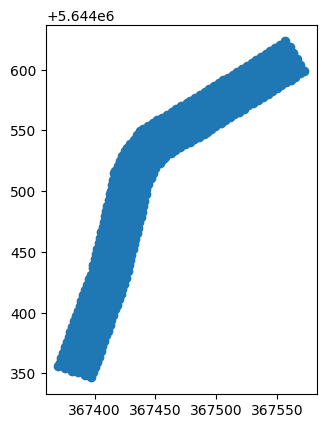

In [9]:
all_images.geometry.centroid.plot()

Get pairs of images and obtain for them relative affines.

In [10]:
def check_transformation(trans):
    scales = np.linalg.norm(trans, axis=0)[:2]
    if np.any(np.abs(scales-1)>0.1):
        #logger.info(f"Scale FAILED ({scales})")
        return False
    shear_dev_1 = np.abs(np.abs(trans[0,0]) - np.abs(trans[1,1]))
    shear_dev_2 = np.abs(np.abs(trans[0,1]) - np.abs(trans[1,0]))
    if shear_dev_1 > 0.1 or shear_dev_2 > 0.1:
        #logger.info(f"Shear dev failed ({shear_dev_1}, {shear_dev_2})")
        return False
    return True

In [11]:
corners_indices = np.array([[0,0,1], [0,CFG.HEIGHT,1], [CFG.WIDTH,CFG.HEIGHT,1], [CFG.WIDTH,0,1]], dtype=np.float32)
if CFG.CACHE and os.path.exists(f"{CACHE_DIR}/all_pairs.pkl"):
    all_pairs = pd.read_pickle(f"{CACHE_DIR}/all_pairs.pkl")
else:
    # logger.info("Computing all pairs")
    recreate_dir(OVERLAYS_DIR)
    stitcher = Stitcher(min_inliers=CFG.MIN_INLIERS, lowe_ratio=CFG.LOWE_RATIO)
    all_pairs_i = []
    all_pairs_j = []
    all_relative_transformations = []
    #buffer footprints to detect intersections of images even if they are not perfectly aligned
    all_footprints_buffered = all_images["footprint"].buffer(CFG.DILATION)
    #all_footprints_buffered = [footprint.buffer(CFG.DILATION) for footprint in all_images["footprint"]]
    #find possible pairs of images
    #iterate over pairs of images without repetition
    def get_pairs(i):
        img_path_i = f"{TIF_DEVIGNETTE_DIR}/{all_images['name'][i]}"
        #logger.info(f"i ({i}) image: {all_images['name'][i]}")
        #img_path_i = f"{TIF_RAW_DIR}/{all_images['name'][i]}"
        img_0 = np.array(Image.open(img_path_i)).squeeze()
        img_0 = np.clip(img_0, np.quantile(img_0, 0.02), np.quantile(img_0, 0.98))
        img_0 = cv.normalize(img_0, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
        all_relative_transformations_ = []
        all_pairs_i_ = []
        all_pairs_j_ = []
        # images_intersecting = all_footprints_buffered.intersects(all_footprints_buffered[i])
        # #get indices of True
        # indices = np.where(images_intersecting)[0]
        # #remove indices <= i
        # indices = indices[indices>i]
        for j in range(i+1,len(all_images)):
            if not all_footprints_buffered[i].intersects(all_footprints_buffered[j]):
                continue
            img_path_j = f"{TIF_DEVIGNETTE_DIR}/{all_images['name'][j]}"
            #logger.info(f"j ({j}) image: {all_images['name'][j]}")
            #img_path_j = f"{TIF_RAW_DIR}/{all_images['name'][j]}"
            img_1 = np.array(Image.open(img_path_j)).squeeze()
            #clamp with as a 0.02 and 0.98 quantile to increase contrast by removing outliers
            img_1 = np.clip(img_1, np.quantile(img_1, 0.02), np.quantile(img_1, 0.98))
            img_1 = cv.normalize(img_1, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
            success = False
            for s in [1, 0.5]:
                # logger.info(f"({i}, {j}) Scale = {s}")
                img_0_s = cv.resize(img_0, None, fx=s, fy=s, interpolation=cv.INTER_AREA)
                img_1_s = cv.resize(img_1, None, fx=s, fy=s, interpolation=cv.INTER_AREA)
                relative_transformation = stitcher.relative_affine(img_0_s, img_1_s)
                if relative_transformation is None:
                    # logger.info(f"({i}, {j}) Relative transformation is None")
                    continue
                relative_transformation = np.array(relative_transformation, dtype=np.float32).reshape(3,3)
                relative_transformation[:,2] /= s
                success = check_transformation(relative_transformation)
                if not success:
                    # logger.info(f"({i}, {j}) Failed")
                    #counts['failed'] +=1
                    continue
                # logger.info(f"({i}, {j}) Success with scale {s}")
                #counts[str(s)]+=1
                break
            if not success:
                continue
            all_relative_transformations_.append(relative_transformation)
            all_pairs_i_.append(i)
            all_pairs_j_.append(j)
        all_relative_transformations_ = np.array(all_relative_transformations_)
        all_pairs_i_ = np.array(all_pairs_i_)
        all_pairs_j_ = np.array(all_pairs_j_)
        return all_pairs_i_, all_pairs_j_, all_relative_transformations_
    
    all_pairs_i, all_pairs_j, all_relative_transformations = zip(*list(p_map(get_pairs, range(len(all_images)))))
    
    ## postprocessing of pairs

    #get indices of pairs of images that are not empty
    non_empty_pairs_i_idx = np.where([len(pairs_i)>0 for pairs_i in all_pairs_i])[0]
    non_empty_pairs_j_idx = np.where([len(pairs_j)>0 for pairs_j in all_pairs_j])[0]
    non_empty_relative_transformations_idx = np.where([len(relative_transformations)>0 for relative_transformations in all_relative_transformations])[0]
    #check that the indices are the same
    assert np.all(non_empty_pairs_i_idx == non_empty_pairs_j_idx)
    assert np.all(non_empty_pairs_i_idx == non_empty_relative_transformations_idx)
    #keep only the non empty sets
    all_pairs_i = [all_pairs_i[i] for i in non_empty_pairs_i_idx]
    all_pairs_j = [all_pairs_j[i] for i in non_empty_pairs_j_idx]
    all_relative_transformations = [all_relative_transformations[i] for i in non_empty_relative_transformations_idx]
    #concatenate
    all_pairs_i = np.concatenate(all_pairs_i)
    all_pairs_j = np.concatenate(all_pairs_j)
    all_relative_transformations = np.concatenate(all_relative_transformations)
    
    all_corners_coords = np.matmul(all_relative_transformations, np.transpose(corners_indices), dtype=np.float32)
    all_pairs = pd.DataFrame({"i": all_pairs_i, "j": all_pairs_j, "rel_trans": list(all_relative_transformations), "corners": list(all_corners_coords)})
    all_pairs.to_pickle(f"{CACHE_DIR}/all_pairs.pkl")

  0%|          | 0/453 [00:00<?, ?it/s]

Visually inspect relative transformations

In [12]:
recreate_dir(OVERLAYS_DIR)
def save_overlay(i, j, relative_transformation, j_corners_coords):
    img0 = np.array(Image.open(f"{TIF_DEVIGNETTE_DIR}/{all_images['name'][i]}"))
    img1 = np.array(Image.open(f"{TIF_DEVIGNETTE_DIR}/{all_images['name'][j]}"))
    img0 = cv.normalize(img0, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
    img1 = cv.normalize(img1, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
    img_overlay = cv.warpAffine(src=img1, M=np.array(relative_transformation)[:2], dsize=img0.shape[::-1])
    # overlay with 50% transparency
    img_overlay = cv.addWeighted(img0, 0.5, img_overlay, 0.5, gamma=0.0)
    #plot corners
    for corner in range(4):
        cv.circle(img_overlay, tuple(j_corners_coords[:,corner][:2].astype(int)), 20, (255, 255, 255), -1)
    cv.imwrite(f"{OVERLAYS_DIR}/overlay_{i}_{j}.png", img_overlay)
    
results = p_map(save_overlay, all_pairs_i, all_pairs_j, all_relative_transformations, all_corners_coords)

  0%|          | 0/9971 [00:00<?, ?it/s]

Interpet pairs as graph and get unconnected components. Only images from component with the largest amount of nodes will processed.

In [13]:
graph = networkx.Graph(all_pairs[["i", "j"]].values.tolist())
#find connected components
components = list(networkx.connected_components(graph))
#get lagest component
component = list(max(components, key=len))

Plot graph

(367360.0624559554, 367582.7867970412, 5644332.795959982, 5644636.989106599)

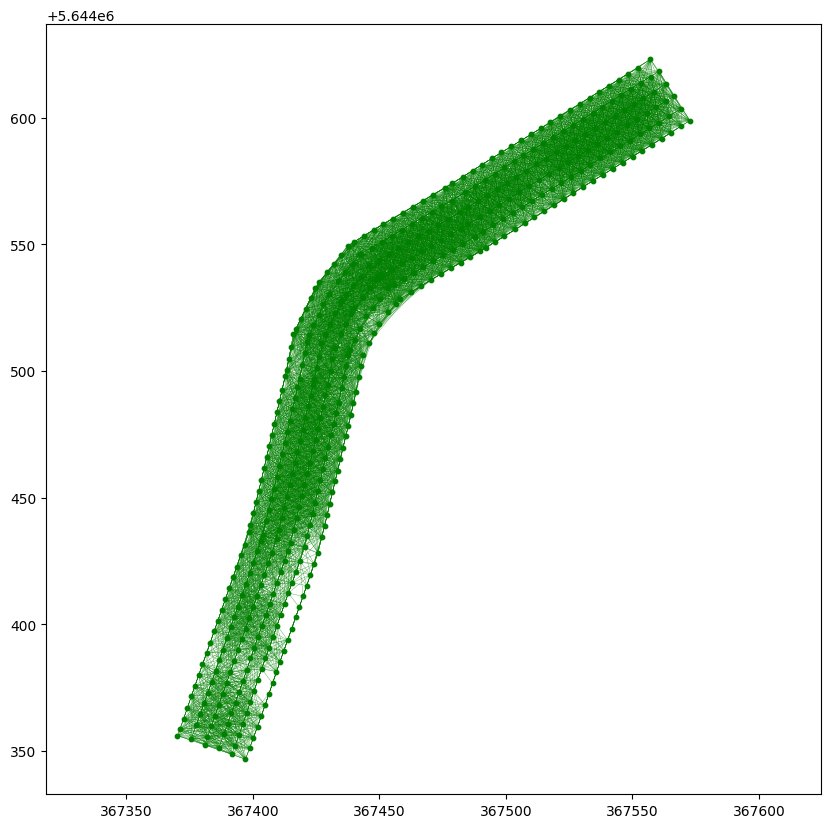

In [14]:
#plot centroids
fig, ax = plt.subplots(figsize=(10,10))
for i, footprint in enumerate(all_images["footprint"].values.tolist()):
    c = "green" if i in component else "red"
    ax.scatter(footprint.centroid.x, footprint.centroid.y, s=10, c=c)
#plot lines between pairs
for i, j in all_pairs[["i", "j"]].values.tolist():
    c = "green" if i in component and j in component else "red"
    ax.plot([all_images["footprint"][i].centroid.x, all_images["footprint"][j].centroid.x], [all_images["footprint"][i].centroid.y, all_images["footprint"][j].centroid.y], color=c, linewidth=0.2)
plt.axis('equal')

Remove elements that are not in the largest component. Indexes in `pairs_i` and `pairs_j` need to be updated.

In [15]:
images = all_images[all_images.index.isin(component)]
images = images.reset_index()
pairs = all_pairs[all_pairs["i"].isin(component) & all_pairs["j"].isin(component)]
#update i and j indexes in pairs
pairs["i"] = pairs["i"].apply(lambda x: images[images["index"]==x].index[0])
pairs["j"] = pairs["j"].apply(lambda x: images[images["index"]==x].index[0])

Globally optimize

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# convert to tensors
thetas = torch.tensor(images["rotation"].values, dtype=torch.float64, requires_grad=True, device=device)
scales_x = torch.tensor(images["scale"].values, dtype=torch.float64, requires_grad=True, device=device)
scales_y = torch.tensor(images["scale"].values, dtype=torch.float64, requires_grad=True, device=device)
shears_x = torch.tensor(np.zeros(len(images)), dtype=torch.float64, requires_grad=False, device=device)
shears_y = torch.tensor(np.zeros(len(images)), dtype=torch.float64, requires_grad=False, device=device)
xs = torch.tensor(images["x"].values, dtype=torch.float64, requires_grad=True, device=device)
ys = torch.tensor(images["y"].values, dtype=torch.float64, requires_grad=True, device=device)
corners_indices = torch.tensor(corners_indices, dtype=torch.float64, device=device)
corners_coords = torch.tensor(np.stack(pairs["corners"]), dtype=torch.float64, device=device)
pairs_i = torch.tensor(pairs["i"].values, dtype=torch.int64, device=device)
pairs_j = torch.tensor(pairs["j"].values, dtype=torch.int64, device=device)
centroid_indices = torch.tensor([CFG.WIDTH/2., CFG.HEIGHT/2., 1.], dtype=torch.float64, device=device)
centroid_coords = torch.tensor([[geometry.centroid.x, geometry.centroid.y, 1.] for geometry in images["footprint"]], dtype=torch.float64, device=device)
# initialize optimizer and scheduler
optimizer = torch.optim.Adam([thetas, scales_x, scales_y, shears_x, shears_y, xs, ys], lr=CFG.INIT_LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=CFG.LR_PLATEAU_FACTOR, patience=CFG.LR_PLATEAU_PATIENCE, cooldown=CFG.LR_PLATEAU_COOLDOWN ,verbose=True)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=CFG.LR_MILESTONES, gamma=0.1)

# iterate n_iter times
best_loss = np.inf
es_counter = 0
losses = []
for k in (pbar := tqdm(range(CFG.N_ITER))):
    optimizer.zero_grad()
    # compute absolute affine transformation
    affines_1 = torch.stack([
        torch.cos(thetas),
        torch.sin(thetas),
        xs,
        torch.sin(thetas),
        -torch.cos(thetas),
        ys,
        torch.zeros(len(component), dtype=torch.float64),
        torch.zeros(len(component), dtype=torch.float64),
        torch.ones(len(component), dtype=torch.float64)]).T.view(-1, 3, 3)
    affines_2 = torch.stack([
        scales_x,
        shears_x,
        torch.zeros(len(component), dtype=torch.float64),
        shears_y,
        scales_y,
        torch.zeros(len(component), dtype=torch.float64),
        torch.zeros(len(component), dtype=torch.float64),
        torch.zeros(len(component), dtype=torch.float64),
        torch.ones(len(component), dtype=torch.float64)]).T.view(-1, 3, 3)
    affines = torch.matmul(affines_1, affines_2)
    # extract i, j affines to estimate relative affines
    affines_i = affines[pairs_i]
    affines_j = affines[pairs_j]
    # get estimated relative affines
    relative_transformations_estimated = torch.matmul(torch.inverse(affines_i), affines_j)
    corners_coords_estimated = torch.matmul(relative_transformations_estimated, np.transpose(corners_indices))
    centroid_coords_estimated = torch.matmul(affines, np.transpose(centroid_indices))
    rel_losses = ((corners_coords_estimated - corners_coords) ** 2).sum(axis=1)**0.5 # relative position losses
    abs_losses = ((centroid_coords_estimated - centroid_coords) ** 2).sum(axis=1)**0.5 # absolute position losses
    rel_loss = rel_losses.mean()
    abs_loss = CFG.ABS_LOSS_FACTOR*abs_losses.mean()
    pbar.set_description(f"rel_loss: {rel_loss.item()}, abs_loss: {abs_loss.item()}")
    loss = rel_loss + abs_loss
    losses.append(loss.item())
    #earli stopping
    if best_loss-loss.item() > CFG.ES_MIN_DELTA:
        best_loss = loss.item()
        best_affines = affines.detach().cpu().numpy()
        es_counter = 0
    else:
        es_counter += 1
        if es_counter > CFG.ES_PATIENCE:
            print("Early stopping")
            break
    
    # back propagate
    loss.backward()
    optimizer.step()
    scheduler.step(loss)

rel_loss: 7.17086131747137, abs_loss: 5.751011416692132e-07:   3%|▎         | 3028/100000 [00:30<14:52, 108.63it/s]  

Epoch 03012: reducing learning rate of group 0 to 1.0000e-04.


rel_loss: 7.164699064359288, abs_loss: 5.761688074616309e-07:   4%|▎         | 3545/100000 [00:35<14:50, 108.34it/s] 

Epoch 03524: reducing learning rate of group 0 to 1.0000e-05.


rel_loss: 7.164538334857417, abs_loss: 5.763136853853345e-07:   4%|▍         | 4044/100000 [00:40<16:59, 94.13it/s]  

Epoch 04025: reducing learning rate of group 0 to 1.0000e-06.


rel_loss: 7.164518158928674, abs_loss: 5.763329169274171e-07:   5%|▍         | 4540/100000 [00:45<16:11, 98.28it/s]  

Epoch 04526: reducing learning rate of group 0 to 1.0000e-07.


rel_loss: 7.164515600113852, abs_loss: 5.763352833958444e-07:   5%|▌         | 5047/100000 [00:50<15:18, 103.39it/s] 

Epoch 05027: reducing learning rate of group 0 to 1.0000e-08.


rel_loss: nan, abs_loss: nan:   5%|▌         | 5425/100000 [00:54<15:53, 99.19it/s]                                  

Early stopping


In [17]:
#csv_string = "name,0_0,0_1,0_2,1_0,1_1,1_2,2_0,2_1,2_2\n"
recreate_dir(GEOTIF_RAW_DIR)
recreate_dir(GEOTIF_DEVIGNETTE_DIR)
def seve_geotiffs(transform, name):
    img2geotif(f"{TIF_RAW_DIR}/{name}", f"{GEOTIF_RAW_DIR}/{name}", transform, CFG.CRS)
    img2geotif(f"{TIF_DEVIGNETTE_DIR}/{name}", f"{GEOTIF_DEVIGNETTE_DIR}/{name}", transform, CFG.CRS)
results = p_map(seve_geotiffs, best_affines, images["name"].values)
# for transform, name in zip(tqdm(best_affines), images["name"].values):
#     img2geotif(f"{TIF_RAW_DIR}/{name}", f"{GEOTIF_RAW_DIR}/{name}", transform, CFG.CRS)
#     img2geotif(f"{TIF_DEVIGNETTE_DIR}/{name}", f"{GEOTIF_DEVIGNETTE_DIR}/{name}", transform, CFG.CRS)
#     csv_string = csv_string + f"{name},{transform[0, 0]},{transform[0, 1]},{transform[0, 2]},{transform[1, 0]},{transform[1, 1]},{transform[1, 2]},{transform[2, 0]},{transform[2, 1]},{transform[2, 2]}\n"
# #save csv string to file
# with open(f"{DATA_DIR}/affines.csv", "w") as f:
#     f.write(csv_string)

  0%|          | 0/453 [00:00<?, ?it/s]

In [18]:
#remove tmp dir
shutil.rmtree(TMP_DIR)